# 4.8 Grouping Data & Aggregating Variables

### This script contains the following points:
#### 1. Import resources
#### 2. Create column 'loyalty_flag'
#### 3. Find the aggregated mean of the “order_number” column grouped by “department_id”
#### 4. Determine whether loyalty has to do with avg price purchased
#### 5. Create a spending flag
#### 6. Create a new column 'days_since_prior_order'

### 1. Import resources

In [2]:
# Import libs
import pandas as pd
import numpy as np
import os

In [3]:
# Set a path variable for the import
path = r'C:\Users\zhoux\Documents\CF-Data Analyst Program\DA-Immersion\10-2023 Instacart Basket Analysis'

In [4]:
# Import data set
ords_prods_merge = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_merged_new_cols.pkl'))

### 2. Create column 'loyalty_flag'

##### Creating the column 'max_order' by aggregating with .transform()

In [15]:
ords_prods_merge['max_order'] = ords_prods_merge.groupby(['user_id'])['order_number'].transform(np.max)

##### Create the column 'loyalty_flag'

In [17]:
ords_prods_merge.loc[ords_prods_merge['max_order'] > 40, 'loyalty_flag'] = 'Loyal customer'

In [18]:
ords_prods_merge.loc[(ords_prods_merge['max_order'] <= 40) & (ords_prods_merge['max_order'] > 10), 'loyalty_flag'] = 'Regular customer'

In [26]:
ords_prods_merge.loc[ords_prods_merge['max_order'] <= 10, 'loyalty_flag'] = 'New customer'

In [27]:
ords_prods_merge['loyalty_flag'].value_counts(dropna = False)

loyalty_flag
Regular customer    15876776
Loyal customer      10284093
New customer         6243990
Name: count, dtype: int64

### 3. Find the aggregated mean of the “order_number” column grouped by “department_id”

In [22]:
df_agg = ords_prods_merge.groupby('department_id').agg({'order_number':['mean']}).droplevel(0, axis = 1).reset_index()
df_agg

,department_id,mean
0,1,15.457838
1,2,17.277920
2,3,17.170395
3,4,17.811403
4,5,15.215751
5,6,16.439806
6,7,17.225802
7,8,15.340650
8,9,15.895474
9,10,20.197148


In [23]:
df_mean

,department_id,mean
0,4,18.825780
1,7,17.472355
2,13,17.993423
3,14,19.246334
4,16,19.463012
5,17,11.294069
6,19,19.305237
7,20,17.599636


The subsets 'df_mean' includes only part of all values from department_id, while the results 'df_agg' for the entire dataframe includes all values under department_id.
The means are also different. For example, department 14 and 16 showed a mean above 19 in the subset, but their mean decreased to approx. 16 and 17 based on the entire dataset. It means we cannot fully trust the statistical stats calculated from a subset, as the real picture may differ by a margin.

### 4. Determine whether loyalty has to do with avg price purchased

The marketing team wants to know whether there’s a difference between the spending habits of the three types of customers identified.

In [28]:
# Check the frequency to make sure there are no errors
ords_prods_merge['loyalty_flag'].value_counts(dropna = False)

loyalty_flag
Regular customer    15876776
Loyal customer      10284093
New customer         6243990
Name: count, dtype: int64

In [31]:
# Take a look at the dataframe to understand which column we need for this task.
ords_prods_merge.head()

,order_id,user_id,eval_set,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,prices,price_range_loc,busiest_day,busiest_days,busiest_period_of_day,max_order,loyalty_flag
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,9.0,Mid-range product,Regularly busy,Regularly busy,Average orders,10,New customer
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,9.0,Mid-range product,Regularly busy,Least busiest days,Average orders,10,New customer
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,9.0,Mid-range product,Regularly busy,Least busiest days,Most orders,10,New customer
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,9.0,Mid-range product,Least busiest day,Least busiest days,Average orders,10,New customer
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,9.0,Mid-range product,Least busiest day,Least busiest days,Most orders,10,New customer


In [30]:
ords_prods_merge.groupby('loyalty_flag')['prices'].mean()

loyalty_flag
Loyal customer      10.386336
New customer        13.294670
Regular customer    12.495717
Name: prices, dtype: float64

The average prices of products purchased by loyal customers are the lowest among the three category of customers.
The average price trend can be summarized as : Loyal customer < Regular customer < New customer. Remark: This is an interesting pattern, what could be the underlying reason?

### 5. Create a spending flag

The team now wants to target different types of spenders in their marketing campaigns. Create a spending flag for each user based on the average price across all their orders using the following criteria:
1. If the mean of the prices of products purchased by a user is lower than 10, then flag them as a “Low spender.”
2. If the mean of the prices of products purchased by a user is higher than or equal to 10, then flag them as a “High spender.”


In [37]:
# Calculate each customer's average spend of products
ords_prods_merge['avg_prods_price'] = ords_prods_merge.groupby(['user_id'])['prices'].transform(np.mean)

In [38]:
ords_prods_merge.head()

,order_id,user_id,eval_set,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,aisle_id,department_id,prices,price_range_loc,busiest_day,busiest_days,busiest_period_of_day,max_order,loyalty_flag,avg_prods_price
0,2539329,1,prior,1,2,8,NaN,196,1,0,...,77,7,9.0,Mid-range product,Regularly busy,Regularly busy,Average orders,10,New customer,6.367797
1,2398795,1,prior,2,3,7,15.0,196,1,1,...,77,7,9.0,Mid-range product,Regularly busy,Least busiest days,Average orders,10,New customer,6.367797
2,473747,1,prior,3,3,12,21.0,196,1,1,...,77,7,9.0,Mid-range product,Regularly busy,Least busiest days,Most orders,10,New customer,6.367797
3,2254736,1,prior,4,4,7,29.0,196,1,1,...,77,7,9.0,Mid-range product,Least busiest day,Least busiest days,Average orders,10,New customer,6.367797
4,431534,1,prior,5,4,15,28.0,196,1,1,...,77,7,9.0,Mid-range product,Least busiest day,Least busiest days,Most orders,10,New customer,6.367797


In [44]:
# Quick check whether the avg price calculation was correct
ords_prods_merge.groupby('user_id')['avg_prods_price'].head()

0           6.367797
1           6.367797
2           6.367797
3           6.367797
4           6.367797
              ...   
32393481    8.100000
32393482    8.100000
32393483    8.100000
32393484    8.100000
32402257    5.800000
Name: avg_prods_price, Length: 1029934, dtype: float64

In [52]:
# Use loc() to add a new column where it categorizes a customer to low or high spender based on their avg product price.
ords_prods_merge.loc[ords_prods_merge['avg_prods_price'] < 10, 'spending_flag'] = 'Low spender'

In [53]:
ords_prods_merge.loc[ords_prods_merge['avg_prods_price'] >= 10, 'spending_flag'] = 'High spender'

In [55]:
# Display the distribution of low and high spenders.
ords_prods_merge['spending_flag'].value_counts(dropna = False)

spending_flag
Low spender     31770614
High spender      634245
Name: count, dtype: int64

### 6. Create a new column 'median_days_since_prior_order'

In order to send relevant notifications to users within the app (for instance, asking users if they want to buy the same item again), the team wants to determine frequent versus non-frequent customers. Create an order frequency flag that marks the regularity of a user’s ordering behavior according to the median in the “days_since_prior_order” column. The criteria for the flag should be as follows:
1. If the median of “days_since_prior_order” is higher than 20, then the customer should be labeled a “Non-frequent customer.”
2. If the median is higher than 10 and lower than or equal to 20, then the customer should be labeled a “Regular customer.”
3. If the median is lower than or equal to 10, then the customer should be labeled a “Frequent customer.”

In [58]:
# Calculate each customer's median “days_since_prior_order”
ords_prods_merge['median_days_since_prior_order'] = ords_prods_merge.groupby(['user_id'])['days_since_prior_order'].transform(np.median)
ords_prods_merge.head(40)

,order_id,user_id,eval_set,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,prices,price_range_loc,busiest_day,busiest_days,busiest_period_of_day,max_order,loyalty_flag,avg_prods_price,spending_flag,median_days_since_prior_order
0,2539329,1,prior,1,2,8,NaN,196,1,0,...,9.0,Mid-range product,Regularly busy,Regularly busy,Average orders,10,New customer,6.367797,Low spender,20.5
1,2398795,1,prior,2,3,7,15.0,196,1,1,...,9.0,Mid-range product,Regularly busy,Least busiest days,Average orders,10,New customer,6.367797,Low spender,20.5
2,473747,1,prior,3,3,12,21.0,196,1,1,...,9.0,Mid-range product,Regularly busy,Least busiest days,Most orders,10,New customer,6.367797,Low spender,20.5
3,2254736,1,prior,4,4,7,29.0,196,1,1,...,9.0,Mid-range product,Least busiest day,Least busiest days,Average orders,10,New customer,6.367797,Low spender,20.5
4,431534,1,prior,5,4,15,28.0,196,1,1,...,9.0,Mid-range product,Least busiest day,Least busiest days,Most orders,10,New customer,6.367797,Low spender,20.5
5,3367565,1,prior,6,2,7,19.0,196,1,1,...,9.0,Mid-range product,Regularly busy,Regularly busy,Average orders,10,New customer,6.367797,Low spender,20.5
6,550135,1,prior,7,1,9,20.0,196,1,1,...,9.0,Mid-range product,Regularly busy,Busiest days,Most orders,10,New customer,6.367797,Low spender,20.5
7,3108588,1,prior,8,1,14,14.0,196,2,1,...,9.0,Mid-range product,Regularly busy,Busiest days,Most orders,10,New customer,6.367797,Low spender,20.5
8,2295261,1,prior,9,1,16,0.0,196,4,1,...,9.0,Mid-range product,Regularly busy,Busiest days,Most orders,10,New customer,6.367797,Low spender,20.5
9,2550362,1,prior,10,4,8,30.0,196,1,1,...,9.0,Mid-range product,Least busiest day,Least busiest days,Average orders,10,New customer,6.367797,Low spender,20.5


In [57]:
# Quick check whether the median calculation was correct
ords_prods_merge.groupby('user_id')['median_days_since_prior_order'].head()

0           20.5
1           20.5
2           20.5
3           20.5
4           20.5
            ... 
32393481    30.0
32393482    30.0
32393483    30.0
32393484    30.0
32402257    30.0
Name: median_days_since_prior_order, Length: 1029934, dtype: float64

In [59]:
# Use loc() to add a new column where it categorizes a customer into one of the 3 spender levels
ords_prods_merge.loc[ords_prods_merge['median_days_since_prior_order'] > 20, 'regularity_flag'] = 'Non-frequent customer'

In [66]:
ords_prods_merge.loc[(ords_prods_merge['median_days_since_prior_order'] <= 20) & (ords_prods_merge['median_days_since_prior_order'] > 10), 'regularity_flag'] = 'Regular customer'

In [67]:
ords_prods_merge.loc[ords_prods_merge['median_days_since_prior_order'] <= 10, 'regularity_flag'] = 'Frequent customer'

In [71]:
ords_prods_merge.head(15)

,order_id,user_id,eval_set,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,price_range_loc,busiest_day,busiest_days,busiest_period_of_day,max_order,loyalty_flag,avg_prods_price,spending_flag,median_days_since_prior_order,regularity_flag
0,2539329,1,prior,1,2,8,NaN,196,1,0,...,Mid-range product,Regularly busy,Regularly busy,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer
1,2398795,1,prior,2,3,7,15.0,196,1,1,...,Mid-range product,Regularly busy,Least busiest days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer
2,473747,1,prior,3,3,12,21.0,196,1,1,...,Mid-range product,Regularly busy,Least busiest days,Most orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer
3,2254736,1,prior,4,4,7,29.0,196,1,1,...,Mid-range product,Least busiest day,Least busiest days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer
4,431534,1,prior,5,4,15,28.0,196,1,1,...,Mid-range product,Least busiest day,Least busiest days,Most orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer
5,3367565,1,prior,6,2,7,19.0,196,1,1,...,Mid-range product,Regularly busy,Regularly busy,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer
6,550135,1,prior,7,1,9,20.0,196,1,1,...,Mid-range product,Regularly busy,Busiest days,Most orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer
7,3108588,1,prior,8,1,14,14.0,196,2,1,...,Mid-range product,Regularly busy,Busiest days,Most orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer
8,2295261,1,prior,9,1,16,0.0,196,4,1,...,Mid-range product,Regularly busy,Busiest days,Most orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer
9,2550362,1,prior,10,4,8,30.0,196,1,1,...,Mid-range product,Least busiest day,Least busiest days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer


In [72]:
# Display the distribution of the 3 levels of spenders.
ords_prods_merge['regularity_flag'].value_counts(dropna = False)

regularity_flag
Frequent customer        21559853
Regular customer          7208564
Non-frequent customer     3636437
NaN                             5
Name: count, dtype: int64

###### There are 5 rows with NaN values, why? Below are the investigations. The NaN in regularity_flag comes from the median calculation. How many NaNs are there in the calculation results?

In [73]:
ords_prods_merge['median_days_since_prior_order'].value_counts(dropna = False)

median_days_since_prior_order
7.0     5682399
6.0     2983604
8.0     2713964
5.0     2486061
4.0     2314289
         ...   
26.5       5514
29.5       5095
1.5        1684
0.5         235
NaN           5
Name: count, Length: 62, dtype: int64

Since there are only 5 rows, we print these rows and further learn about them.

In [77]:
print(ords_prods_merge[ords_prods_merge['median_days_since_prior_order'].isnull()])

          order_id  user_id eval_set  order_number  orders_day_of_week  \
13645692    895835   159838    prior             1                   0   
17251990    895835   159838    prior             1                   0   
17622767    895835   159838    prior             1                   0   
24138593    895835   159838    prior             1                   0   
25880002    895835   159838    prior             1                   0   

          order_hour_of_day  days_since_prior_order  product_id  \
13645692                 17                     NaN       10749   
17251990                 17                     NaN       33401   
17622767                 17                     NaN       23695   
24138593                 17                     NaN       21334   
25880002                 17                     NaN       22198   

          add_to_cart_order  reordered  ...    price_range_loc  busiest_day  \
13645692                  3          0  ...  Mid-range product  Busiest d

We found that the 5 rows all belong to one user_id and one order_id. Additionally, this single order is the only order placed by this customer. Because there are no previous orders and the customer hasn't come back since, there's no median value of the days between orders to be calculated, thus resulting in a NaN. If this is the case, then all non-returning customers with only one order should have NaN. Is that the case?

Since we have previously calculated the total oders placed by each customer, we can check how many customers have only placed 1 order.

In [93]:
ords_prods_merge['max_order'].value_counts()

max_order
99    1171333
8      811843
6      811396
9      810213
7      803979
       ...   
97      44949
98      44587
96      40453
2           6
1           5
Name: count, Length: 99, dtype: int64

###### It turns out that this customer with user_id 159838 is the only non-returning customer with a single order. Therefore, the NaN values in 'regularity_flag' is not an error, but a result due to this customer. 

##### Export as .pkl

In [94]:
ords_prods_merge.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'orders_products_merged_new_flags.pkl'))

###### Extra data cleaning

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

<Axes: ylabel='Frequency'>

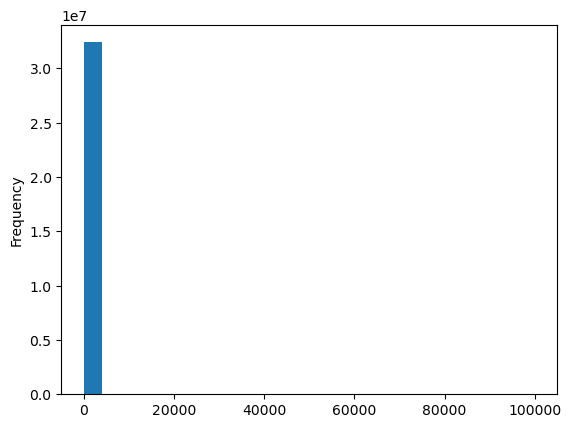

In [95]:
ords_prods_merge['prices'].plot.hist(bins = 25)

In [96]:
ords_prods_merge['prices'].describe()

count    3.240486e+07
mean     1.198023e+01
std      4.956554e+02
min      1.000000e+00
25%      4.200000e+00
50%      7.400000e+00
75%      1.130000e+01
max      9.999900e+04
Name: prices, dtype: float64

In [97]:
ords_prods_merge['prices'].mean()

11.980225638383454

In [98]:
ords_prods_merge['prices'].median()

7.4

In [99]:
ords_prods_merge['prices'].max()

99999.0

<Axes: xlabel='prices', ylabel='prices'>

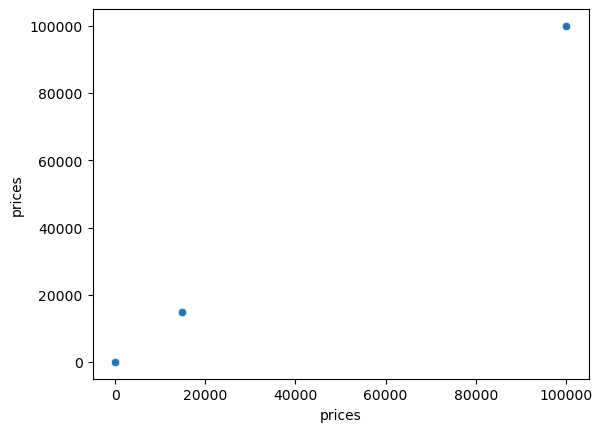

In [102]:
sns.scatterplot(x = 'prices', y = 'prices', data = ords_prods_merge)

In [103]:
# Display all columns (otherwise the prices column will become "...")
pd.set_option('display.max_columns', None)
ords_prods_merge.loc[ords_prods_merge['prices'] > 100]

,order_id,user_id,eval_set,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,prices,price_range_loc,busiest_day,busiest_days,busiest_period_of_day,max_order,loyalty_flag,avg_prods_price,spending_flag,median_days_since_prior_order,regularity_flag
10030345,912404,17,prior,12,2,14,5.0,21553,5,0,Lowfat 2% Milkfat Cottage Cheese,108,16,14900.0,High range product,Regularly busy,Regularly busy,Most orders,40,Regular customer,108.648299,High spender,5.0,Frequent customer
10030346,603376,17,prior,22,6,16,4.0,21553,3,1,Lowfat 2% Milkfat Cottage Cheese,108,16,14900.0,High range product,Regularly busy,Regularly busy,Most orders,40,Regular customer,108.648299,High spender,5.0,Frequent customer
10030347,3264360,135,prior,2,2,21,13.0,21553,6,0,Lowfat 2% Milkfat Cottage Cheese,108,16,14900.0,High range product,Regularly busy,Regularly busy,Average orders,4,New customer,1154.792308,High spender,12.0,Regular customer
10030348,892534,135,prior,3,0,8,12.0,21553,3,1,Lowfat 2% Milkfat Cottage Cheese,108,16,14900.0,High range product,Busiest day,Busiest days,Average orders,4,New customer,1154.792308,High spender,12.0,Regular customer
10030349,229704,342,prior,8,1,19,30.0,21553,9,0,Lowfat 2% Milkfat Cottage Cheese,108,16,14900.0,High range product,Regularly busy,Busiest days,Average orders,16,Regular customer,114.426619,High spender,23.0,Non-frequent customer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29166209,2249946,204099,prior,29,0,8,4.0,33664,1,0,2 % Reduced Fat Milk,84,16,99999.0,High range product,Busiest day,Busiest days,Average orders,39,Regular customer,1106.743956,High spender,4.0,Frequent customer
29166210,2363282,204099,prior,31,0,9,2.0,33664,1,1,2 % Reduced Fat Milk,84,16,99999.0,High range product,Busiest day,Busiest days,Most orders,39,Regular customer,1106.743956,High spender,4.0,Frequent customer
29166211,3181945,204395,prior,13,3,15,8.0,33664,25,0,2 % Reduced Fat Milk,84,16,99999.0,High range product,Regularly busy,Least busiest days,Most orders,15,Regular customer,451.153540,High spender,5.0,Frequent customer
29166212,2486215,205227,prior,7,3,20,4.0,33664,8,0,2 % Reduced Fat Milk,84,16,99999.0,High range product,Regularly busy,Least busiest days,Average orders,12,Regular customer,1178.381871,High spender,12.0,Regular customer


In [104]:
# Turn these abnormal values into NaN
ords_prods_merge.loc[ords_prods_merge['prices'] > 100, 'prices'] = np.nan

In [105]:
# Check whether the replacement was successful
ords_prods_merge['prices'].max()

25.0

In [106]:
ords_prods_merge.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'orders_products_merged_cleaned_for_viz.pkl'))